In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

model_path = 'drive/MyDrive/modelsfortesiscritta/window8regression_model.{epoch:02d}-{val_loss:.2f}.h5'

#print(tensorflow.__version__)
print(keras.__version__)

2.5.0


In [ ]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('drive/MyDrive/ReteTesiFustelle/train_fustelle30min.csv')

train_df = train_df.sort_values(['Id_fustella','Cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('drive/MyDrive/ReteTesiFustelle/test_fustelle30min.csv')


# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('drive/MyDrive/ReteTesiFustelle/RUL30min.csv')
truth_df = truth_df.iloc[: , 1:]
#truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True) # TODO, rimuovere o no?
test_df.head()

,Unnamed: 0,Id_fustella,Cycle,Velocita,Rotazioni,Temperatura,Umidita,Errori
0,0,0,1,3,5580,14.937562,77.0,16
1,1,0,2,3,10980,15.483973,77.0,39
2,2,0,3,3,16380,15.483973,77.0,59
3,3,0,4,3,21780,16.000000,77.0,89
4,4,0,5,3,27180,16.000000,77.0,118


In [ ]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('Id_fustella')['Cycle'].max()).reset_index()
rul.columns = ['Id_fustella', 'max']
train_df = train_df.merge(rul, on=['Id_fustella'], how='left')
train_df['RUL'] = train_df['max'] - train_df['Cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Id_fustella','Cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)
train_df.head()


,Unnamed: 0,Id_fustella,Cycle,Velocita,Rotazioni,Temperatura,Umidita,Errori,RUL,label1,label2,cycle_norm
0,0.000000,0,1,0.714286,0.008847,0.389785,0.926316,0.001551,16,1,1,0.000000
1,0.000154,0,2,0.714286,0.020833,0.410126,0.884211,0.004739,15,1,2,0.003425
2,0.000309,0,3,0.714286,0.032820,0.410126,0.884211,0.008832,14,1,2,0.006849
3,0.000463,0,4,0.714286,0.044806,0.431214,0.852632,0.015984,13,1,2,0.010274
4,0.000617,0,5,0.714286,0.056792,0.431214,0.852632,0.027939,12,1,2,0.013699


In [ ]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['Cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Id_fustella')['Cycle'].max()).reset_index()
rul.columns = ['Id_fustella', 'max']
truth_df.columns = ['more']
truth_df['Id_fustella'] = truth_df.index 
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['Id_fustella'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)
test_df.head()


   Unnamed: 0  Id_fustella  Cycle  ...   Umidita    Errori  cycle_norm
0    0.000000            0      1  ...  0.757895  0.000086    0.000000
1    0.000154            0      2  ...  0.757895  0.000582    0.003425
2    0.000309            0      3  ...  0.757895  0.001012    0.006849
3    0.000463            0      4  ...  0.757895  0.001659    0.010274
4    0.000617            0      5  ...  0.757895  0.002283    0.013699

[5 rows x 9 columns]


,Unnamed: 0,Id_fustella,Cycle,Velocita,Rotazioni,Temperatura,Umidita,Errori,cycle_norm,RUL,label1,label2
0,0.000000,0,1,0.142857,0.001769,0.548349,0.757895,0.000086,0.000000,118,0,0
1,0.000154,0,2,0.142857,0.006906,0.556989,0.757895,0.000582,0.003425,117,0,0
2,0.000309,0,3,0.142857,0.012043,0.556989,0.757895,0.001012,0.006849,116,0,0
3,0.000463,0,4,0.142857,0.017180,0.565149,0.757895,0.001659,0.010274,115,0,0
4,0.000617,0,5,0.142857,0.022317,0.565149,0.757895,0.002283,0.013699,114,0,0


In [ ]:
# pick a large window size of 50 cycles
sequence_length = 64

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols = ['Velocita','Rotazioni','Temperatura','Umidita','Errori', 'cycle_norm']

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['Id_fustella']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['Id_fustella']==id], sequence_length, sequence_cols)) 
           for id in train_df['Id_fustella'].unique() if len(train_df[train_df['Id_fustella']==id]) >= sequence_length)

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['Id_fustella']==id], sequence_length, ['RUL']) 
             for id in train_df['Id_fustella'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

223
(3187, 64, 6)


(3187, 1)

In [ ]:
##################################
# Modeling
##################################

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 64, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
____________________________________________________

In [ ]:
# fit the network
#model.load_weights(model_path)
#model.load_weights('/content/drive/MyDrive/checkpointsmodel2/regression_model.115-20087.74.h5')
history = model.fit(seq_array, label_array, epochs=200, batch_size=50, validation_split=0.05, verbose=2, #initial_epoch=115 ,# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
          callbacks = [keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


Epoch 1/200
61/61 - 19s - loss: 11219.9883 - mae: 83.8956 - r2_keras: -1.6600e+00 - val_loss: 6686.5244 - val_mae: 68.4565 - val_r2_keras: -2.6636e+01
Epoch 2/200
61/61 - 0s - loss: 10568.4824 - mae: 80.6100 - r2_keras: -1.5223e+00 - val_loss: 6286.0200 - val_mae: 65.9536 - val_r2_keras: -2.6747e+01
Epoch 3/200
61/61 - 0s - loss: 10112.1191 - mae: 78.2815 - r2_keras: -1.4070e+00 - val_loss: 5910.4302 - val_mae: 63.6061 - val_r2_keras: -2.7466e+01
Epoch 4/200
61/61 - 0s - loss: 9659.1475 - mae: 76.0737 - r2_keras: -1.3041e+00 - val_loss: 5550.4404 - val_mae: 61.3561 - val_r2_keras: -2.8798e+01
Epoch 5/200
61/61 - 0s - loss: 9223.8506 - mae: 74.0023 - r2_keras: -1.2041e+00 - val_loss: 5205.5259 - val_mae: 59.2007 - val_r2_keras: -3.0758e+01
Epoch 6/200
61/61 - 0s - loss: 8816.1680 - mae: 72.1139 - r2_keras: -1.1023e+00 - val_loss: 4875.5635 - val_mae: 57.1386 - val_r2_keras: -3.3377e+01
Epoch 7/200
61/61 - 0s - loss: 8403.1064 - mae: 70.1999 - r2_keras: -9.9725e-01 - val_loss: 4564.1553 

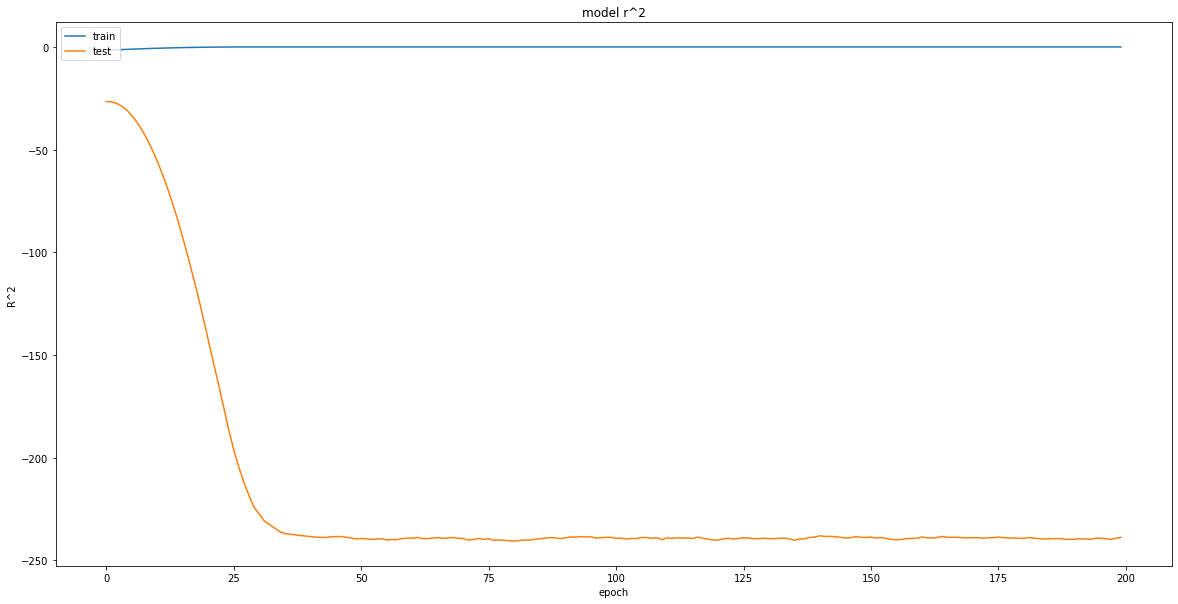

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(20, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
ciao=3475423423434
fig_acc.savefig("model_r2.png")


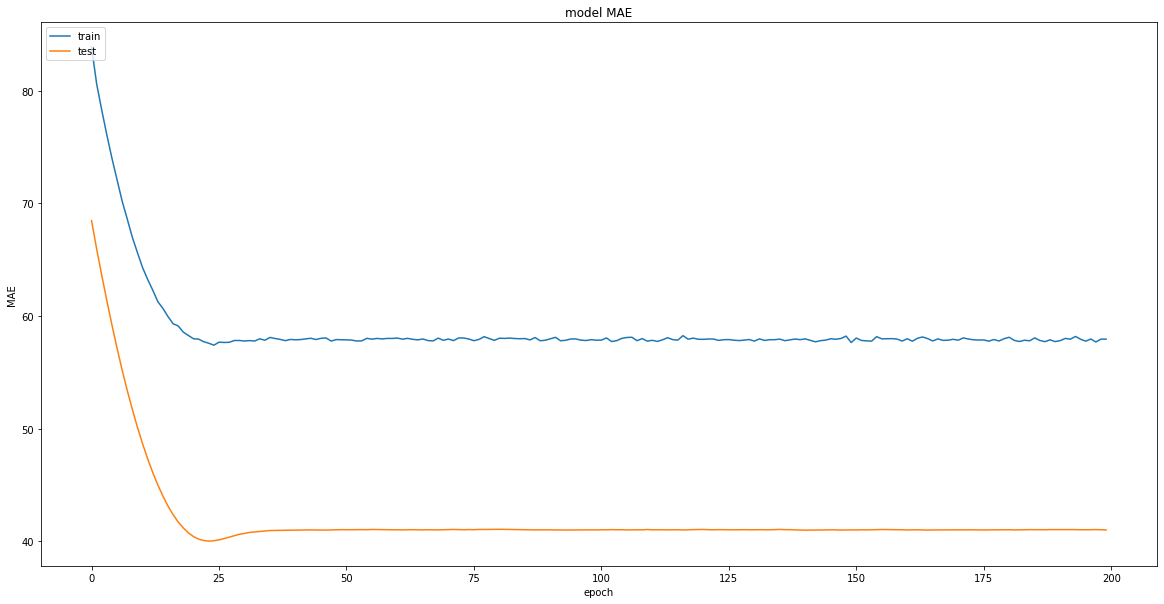

In [ ]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(20, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

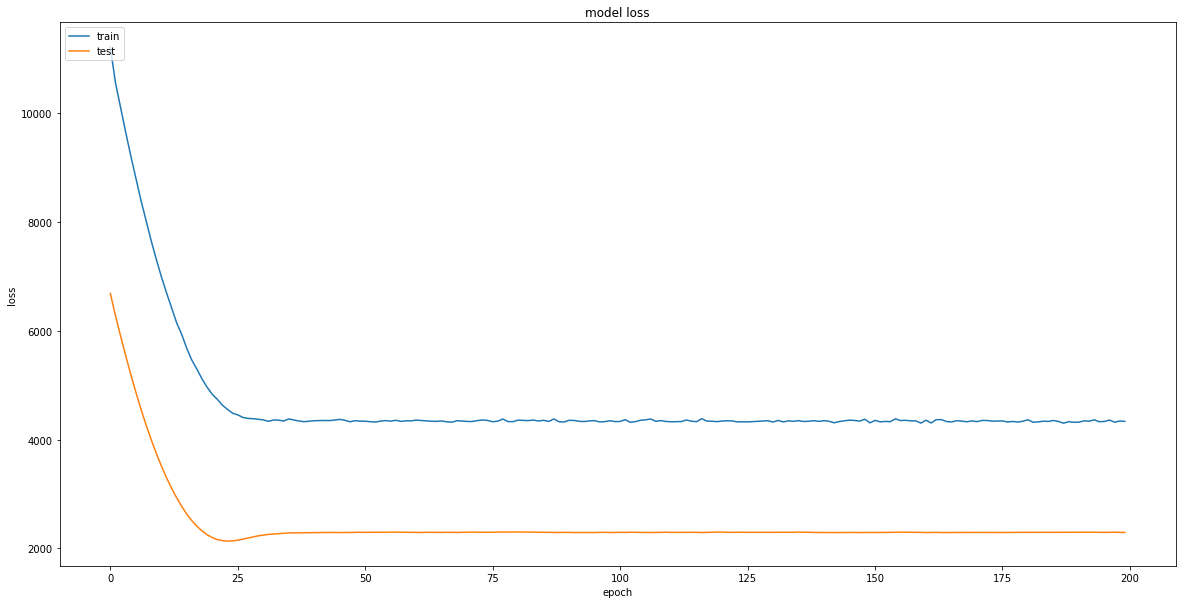

In [ ]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

16/16 [==============================] - 0s 5ms/step - loss: 4200.3208 - mae: 56.9268 - r2_keras: -0.2207

MAE: 56.9267578125

R^2: -0.22073903679847717
16/16 [==============================] - 1s 7ms/step


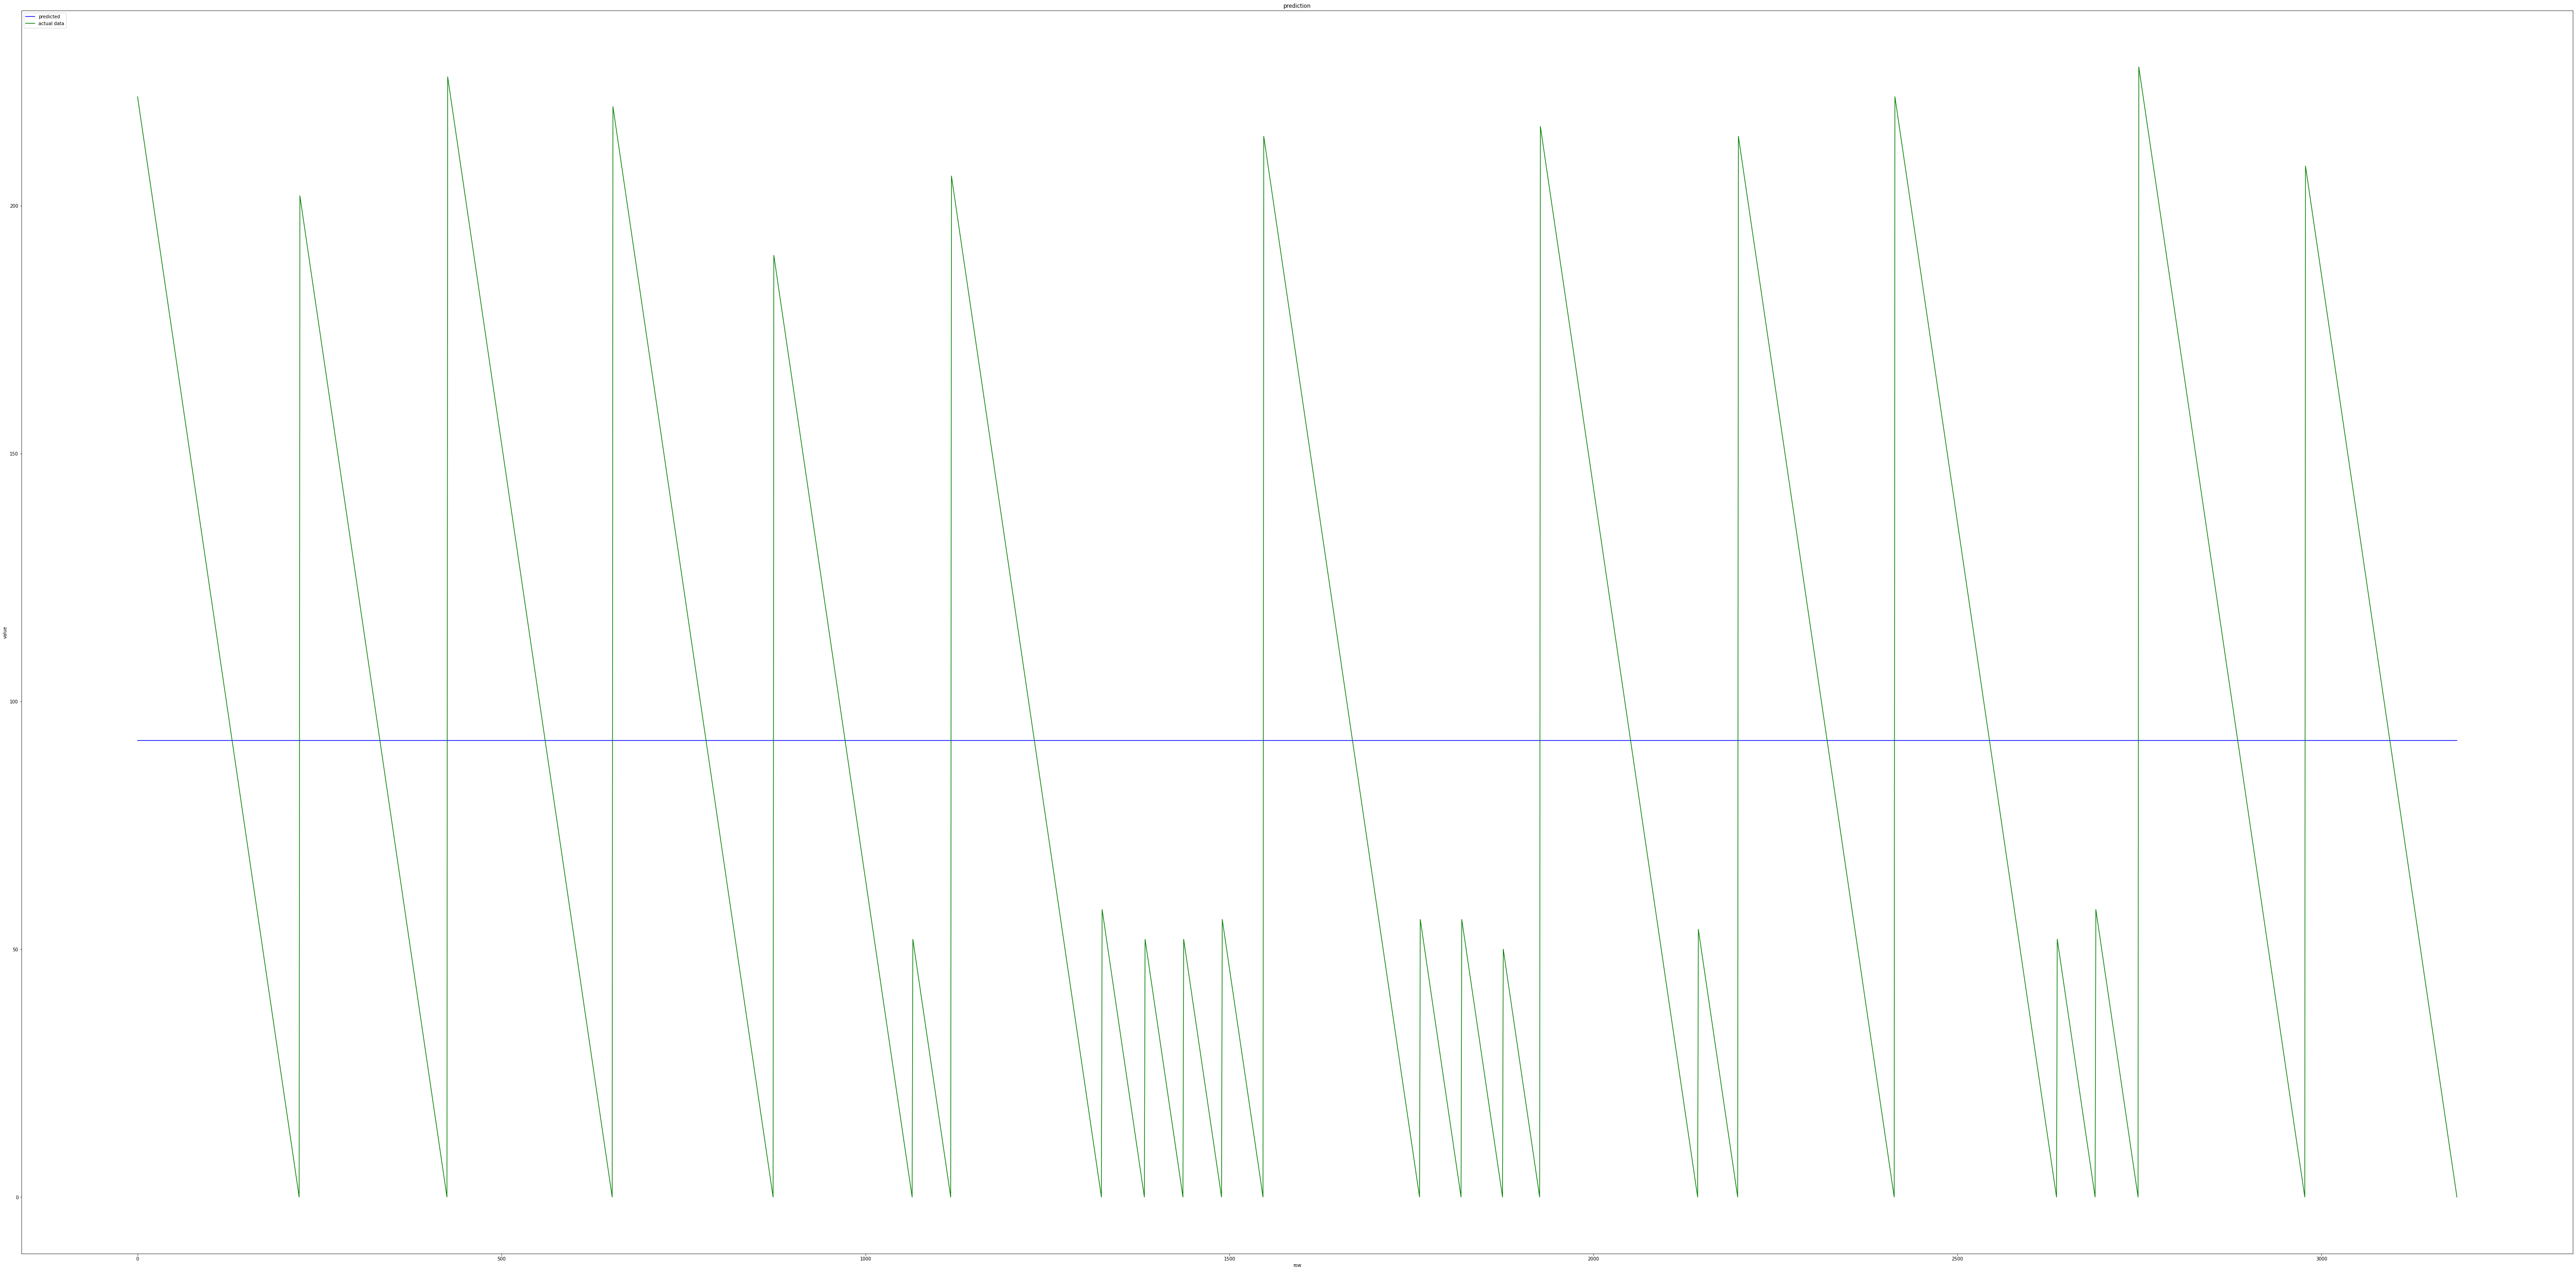

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred_train = model.predict(seq_array,verbose=1, batch_size=200)
y_true_train = label_array

test_set = pd.DataFrame(y_pred_train)
test_set.to_csv('submit_train.csv', index = None)
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_train, color="blue")
plt.plot(y_true_train, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify_train.png")

In [ ]:
##################################
# EVALUATE ON TEST DATA
##################################
"""
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['Id_fustella']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['Id_fustella'].unique() if len(test_df[test_df['Id_fustella']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)
print(test_df)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['Id_fustella']==id]) >= sequence_length for id in test_df['Id_fustella'].unique()]
label_array_test_last = test_df.groupby('Id_fustella')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
#print(label_array_test_last)
"""
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
   data_matrix = id_df[seq_cols].values
   num_elements = data_matrix.shape[0]
   test_array=[]
   for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)): test_array.append(data_matrix[start:stop, :])
   return np.array(test_array)

# pick the feature columns 
#sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['Velocita', 'Rotazioni', 'Temperatura', 'Umidita', 'Errori', 'cycle_norm']
#sequence_cols.extend(sensor_cols)

# generate the sequences for each id in the test data (for each id with >=50 cycles = 93 id)
seq_gen_test = [gen_sequence(test_df[test_df['Id_fustella']==id], sequence_length, sequence_cols)
                for id in test_df['Id_fustella'].unique() if len(test_df[test_df['Id_fustella']==id]) >= sequence_length]
# and convert to numpy array
seq_array_test_last = np.concatenate(list(seq_gen_test)).astype(np.float32)

print(seq_array_test_last.shape)
print("The shape of the test set: {} rows, {} cycles and {} features.".format(seq_array_test_last.shape[0], seq_array_test_last.shape[1], seq_array_test_last.shape[2]))



# function to generate labels
def gen_labels(id_df, seq_length, label):
  data_matrix = id_df[label].values
  num_elements = data_matrix.shape[0]
  return data_matrix[seq_length-1: num_elements+1]

# generate labels
label_gen_test = [gen_labels(test_df[test_df['Id_fustella']==id], sequence_length, ['RUL']) for id in test_df['Id_fustella'].unique()
                  if len(test_df[test_df['Id_fustella']==id]) >= sequence_length]
# and convert to numpy array
label_array_test_last = np.concatenate(list(label_gen_test)).astype(np.float32)

print(label_array_test_last.shape)


(1913, 64, 6)
The shape of the test set: 1913 rows, 64 cycles and 6 features.
(1913, 1)


60/60 - 2s - loss: 4712.7461 - mae: 59.8030 - r2_keras: -3.4151e+01

MAE: 59.8029670715332

R^2: -34.151371002197266


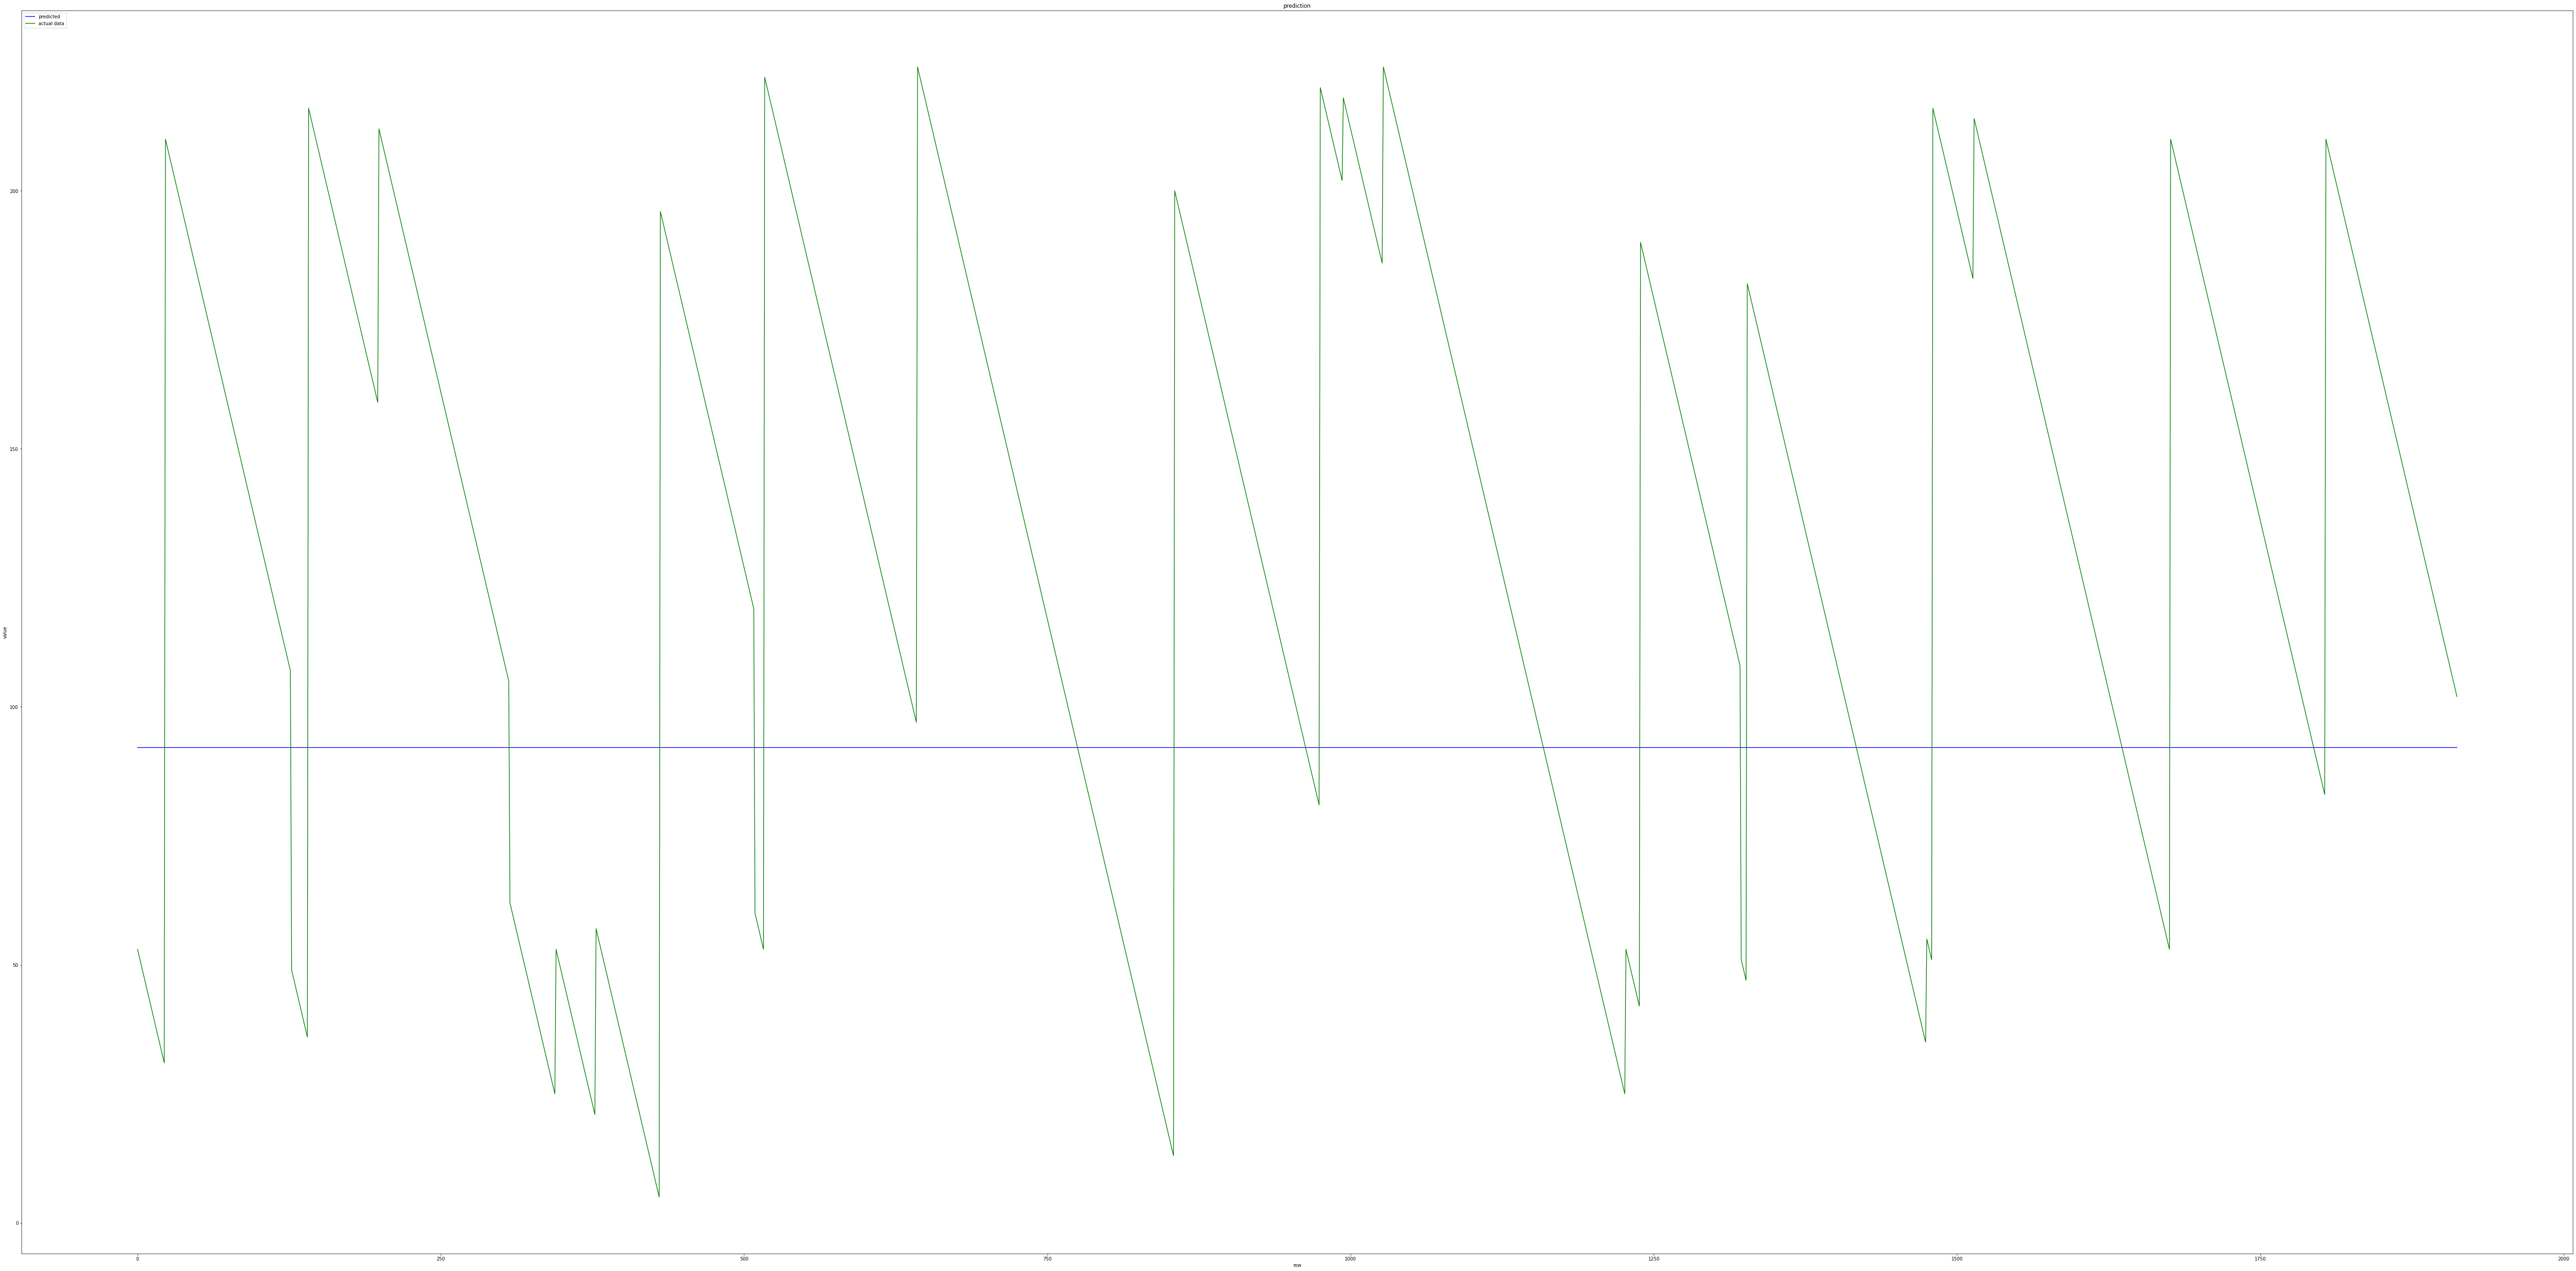

In [ ]:
#if os.path.isfile(model_path):
#estimator = load_model('/content/drive/MyDrive/checkpointsmodel2/regression_model.115-20087.74.h5',custom_objects={'r2_keras': r2_keras})
estimator = model
estimator.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)

print('\nMAE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))

y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")

[(1, 29), (29, 58), (58, 86), (86, 115), (115, 144), (144, 172), (172, 201), (201, 229), (229, 258), (258, 287)]


[Text(0, 0, '(1, 29)'),
 Text(0, 0, '(29, 58)'),
 Text(0, 0, '(58, 86)'),
 Text(0, 0, '(86, 115)'),
 Text(0, 0, '(115, 144)'),
 Text(0, 0, '(144, 172)'),
 Text(0, 0, '(172, 201)'),
 Text(0, 0, '(201, 229)'),
 Text(0, 0, '(229, 258)'),
 Text(0, 0, '(258, 287)')]

<Figure size 7200x720 with 0 Axes>

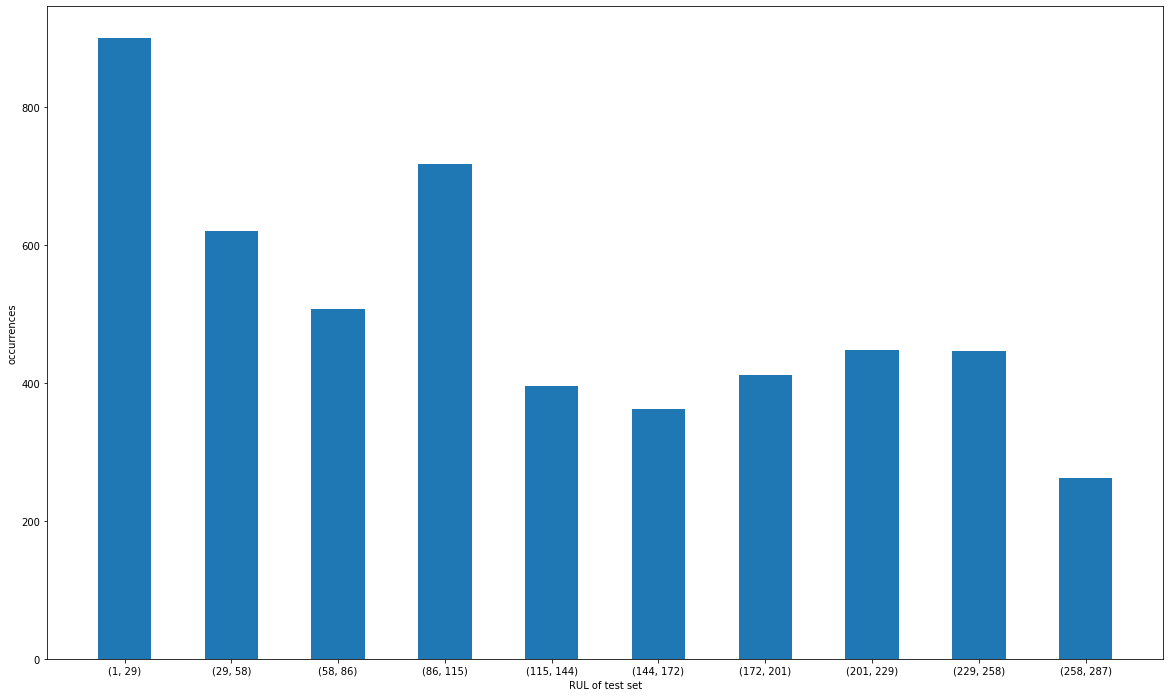

In [ ]:
plt.figure(figsize=(100,10))
fig, ax = plt.subplots(figsize=(20,12))

prova2 = ax.hist(test_df['RUL'], bins=10, rwidth=0.5)
tickmessi = []
tickmessi2 = []
for index in range(0,(len(prova2[1])-1)):
    tickmessi.append((int(prova2[1][index]),int(prova2[1][index+1])))
    tickmessi2.append((prova2[1][index]+prova2[1][index+1])/2)
print(tickmessi)
ax.set_xlabel("RUL of test set")
ax.set_ylabel("occurrences")
ax.set_xticks(tickmessi2)
ax.set_xticklabels(tickmessi)


In [ ]:
array_MAE = []
intervaldefined = [tickmessi]
conditions = [((test_df['RUL'] > 0) & (test_df['RUL'] < 29)),((test_df['RUL'] > 29) & (test_df['RUL'] < 58)),((test_df['RUL'] > 58) & (test_df['RUL'] < 86)),
           ((test_df['RUL'] > 86) & (test_df['RUL'] < 115)),((test_df['RUL'] > 115) & (test_df['RUL'] < 144)),((test_df['RUL'] > 144) & (test_df['RUL'] < 172)),
           ((test_df['RUL'] > 172) & (test_df['RUL'] < 201)),((test_df['RUL'] > 201) & (test_df['RUL'] < 229)),((test_df['RUL'] > 229) & (test_df['RUL'] < 258)),
           ((test_df['RUL'] > 258) & (test_df['RUL'] < 287))]
valoridausare=[]
for index in range(0,10):
    test_df1 =test_df[conditions[index]]
    print(len(test_df1))

    # pick the feature columns 
    #sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['Velocita', 'Rotazioni', 'Temperatura', 'Umidita', 'Errori', 'cycle_norm']
    #sequence_cols.extend(sensor_cols)

    # generate the sequences for each id in the test data (for each id with >=50 cycles = 93 id)
    seq_gen_test = [gen_sequence(test_df1[test_df1['Id_fustella']==id], sequence_length, sequence_cols)
                    for id in test_df['Id_fustella'].unique() if len(test_df[test_df['Id_fustella']==id]) >= sequence_length]
    # and convert to numpy array
    try:
      seq_array_test_last = np.concatenate(list(seq_gen_test)).astype(np.float32)
    except:
      pass


    # generate labels
    label_gen_test = [gen_labels(test_df1[test_df1['Id_fustella']==id], sequence_length, ['RUL']) for id in test_df1['Id_fustella'].unique()
                      if len(test_df[test_df['Id_fustella']==id]) >= sequence_length]
    # and convert to numpy array
    label_array_test_last = np.concatenate(list(label_gen_test)).astype(np.float32)

    estimator = model
    # test metrics
    print(tickmessi[index])
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print("")



871
(1, 29)


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:971: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored